In [71]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

In [164]:
project_path = r'D:\UCBerkeley\CourseWork\202001\W251\Homework\Project'
dir_train = 'train_videos'
test_video = 'ASL_2006_10_10_scene2-camera1_AGAIN_v0_9.mov'
# test_video = 'ASL_2008_01_11_scene9-camera1_AGAIN_v0_0.mov'
# test_video = 'ASL_2011_06_08_Brady_scene33-camera1_DEPOSIT_v0_4.mov'
cap = cv2.VideoCapture(os.path.join(project_path, dir_train, test_video))

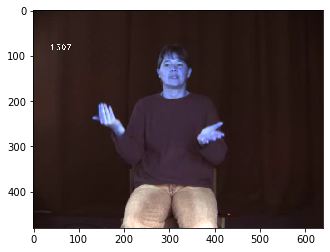

In [165]:
ret, first_frame = cap.read()
plt.imshow(first_frame)

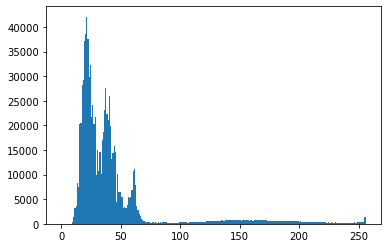

In [166]:
plt.hist(first_frame.ravel(),256,[0,256]); plt.show()

In [167]:
first_frame.shape

(480, 640, 3)

[[272  95  75  75]]


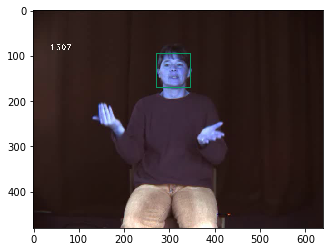

(<matplotlib.image.AxesImage at 0x2470eb7c048>, None)

In [170]:
# Reference for this cell: https://docs.opencv.org/4.0.0-beta/d4/d8c/tutorial_py_shi_tomasi.html
prev_gray = cv2.cvtColor(first_frame,cv2.COLOR_BGR2GRAY)

upper_body_cascade = cv2.CascadeClassifier(r'D:\UCBerkeley\CourseWork\202001\W251\Homework\Project\haarcascade_frontalface_default.xml')
upper_body = upper_body_cascade.detectMultiScale(first_frame, scaleFactor=1.2 , minNeighbors=1)
print(upper_body)

# Only keep the first upper body detection
upper_x, upper_y, upper_w, upper_h = upper_body[0]

# Draw rectangles around upper body 
for (x,y,w,h) in upper_body:
    cv2.rectangle(first_frame, (x,y), (x+w, y+h), (12,150,100),2)
    
    
# lower_body_cascade = cv2.CascadeClassifier(r'D:\UCBerkeley\CourseWork\202001\W251\Homework\Project\haarcascade_lowerbody.xml')
# lower_body = lower_body_cascade.detectMultiScale(first_frame, scaleFactor=1.02 , minNeighbors=1)
# print(lower_body)
# for (x,y,w,h) in lower_body:
#     cv2.rectangle(first_frame, (x,y), (x+w, y+h), (255,100,255),2)

plt.imshow(first_frame),plt.show()

In [171]:
def valid_point(x, y):
    valid = True
    # Only keep the upper body
    # if upper_x < x < upper_x + upper_w and upper_y < y < upper_y + upper_h:
    #     valid = True
    # Do not detect edges for the top left corner where frame number is displayed
    if x < 200 and y < 100:
        valid = False
    return valid

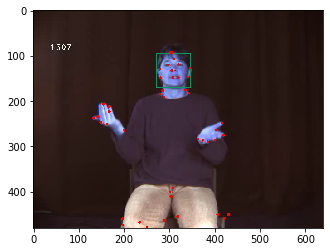

(<matplotlib.image.AxesImage at 0x2470fbb8748>, None)

In [172]:
# Reference for cv2.goodFeaturesToTrack: https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=goodfeaturestotrack
prev_corners = cv2.goodFeaturesToTrack(prev_gray, maxCorners=50,qualityLevel=0.01,minDistance=10)
prev_corners_int = np.int0(prev_corners)
# Plot the good features to track
for i in prev_corners_int:
    x,y = i.ravel()
    # Check whether the point is valid
    if valid_point(x, y):
        cv2.circle(first_frame,(x,y),3,255,-1)
        
plt.imshow(first_frame),plt.show()

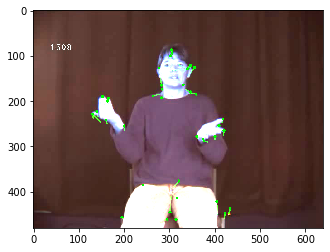

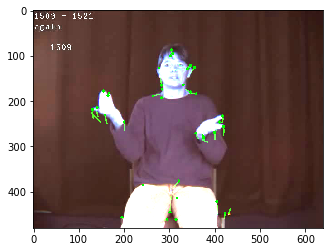

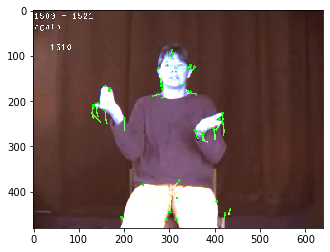

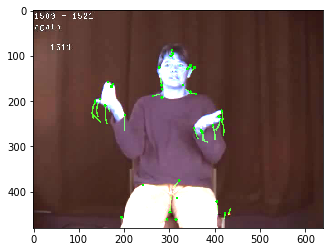

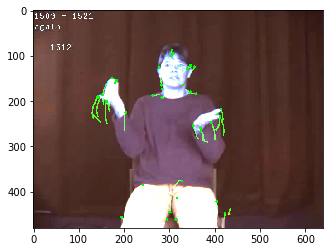

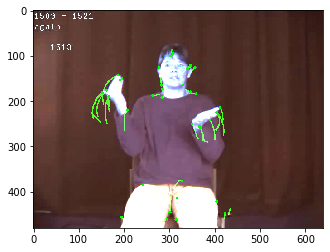

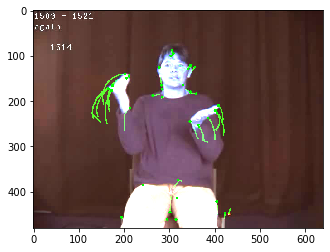

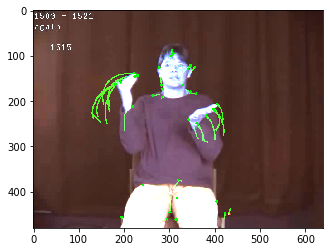

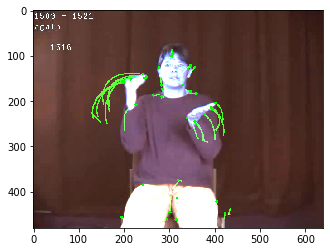

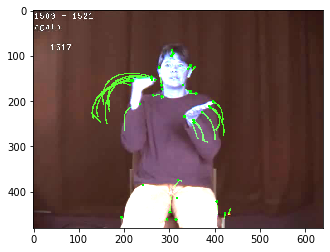

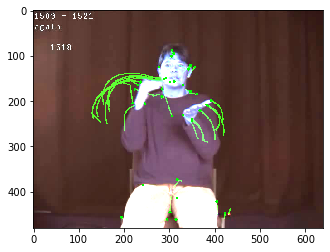

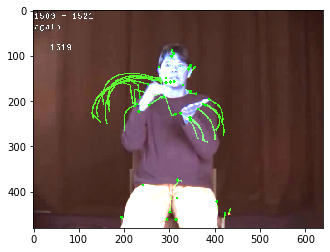

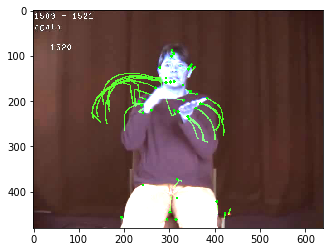

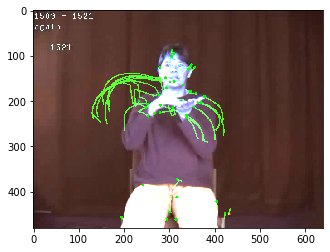

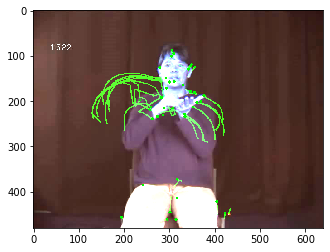

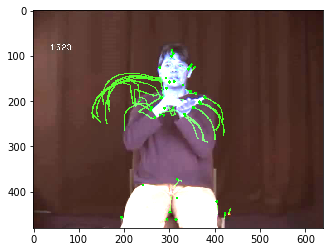

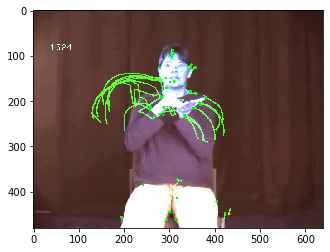

In [173]:
mask = np.zeros_like(first_frame)
# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize = (15,15), maxLevel = 1, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Variable for color to draw optical flow track
color = (0, 255, 0)
while(cap.isOpened()):
    # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
    ret, frame = cap.read()
    # Converts each frame to grayscale - we previously only converted the first frame to grayscale
    frame = cv2.convertScaleAbs(frame, alpha=2, beta=0)
    try:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    except:
        break
    # Calculates sparse optical flow by Lucas-Kanade method
    # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowpyrlk
    next_corners, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_corners, None, **lk_params)
    # Selects good feature points for previous position
    temp_prev = prev_corners[status == 1]
    # Selects good feature points for next position
    temp_next = next_corners[status == 1]
    prev_corners_good =[]
    for i in temp_prev:
        x,y = i.ravel()
        if valid_point(x, y):
            prev_corners_good.append(np.array([x,y]))
    prev_corners_good = np.array(prev_corners_good)
    next_corners_good =[]
    for i in temp_next:
        x,y = i.ravel()
        if valid_point(x, y):
            next_corners_good.append(np.array([x,y]))
    next_corners_good = np.array(next_corners_good)
    # Draws the optical flow tracks
    for i, (new, old) in enumerate(zip(next_corners_good, prev_corners_good)):
        # Returns a contiguous flattened array as (x, y) coordinates for new point
        a, b = new.ravel()
        # Returns a contiguous flattened array as (x, y) coordinates for old point
        c, d = old.ravel()
        # Draws line between new and old position with green color and 2 thickness
        mask = cv2.line(mask, (a, b), (c, d), color, 2)
        # Draws filled circle (thickness of -1) at new position with green color and radius of 3
        frame = cv2.circle(frame, (a, b), 3, color, -1)
    # Overlays the optical flow tracks on the original frame
    output = cv2.add(frame, mask)
    # Updates previous frame
    prev_gray = gray.copy()
    # Updates previous good feature points
    prev_corners = next_corners_good.reshape(-1, 1, 2)
    # Opens a new window and displays the output frame
    # cv2.imshow("sparse optical flow", output)
    plt.imshow(output),plt.show()
    # Frames are read by intervals of 10 milliseconds. The programs breaks out of the while loop when the user presses the 'q' key
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
# The following frees up resources and closes all windows
cap.release()
cv2.destroyAllWindows()

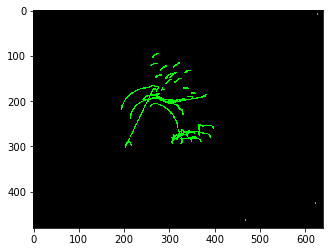

(<matplotlib.image.AxesImage at 0x2471e672cc8>, None)

In [55]:
plt.imshow(mask),plt.show()

In [56]:
# save the image
plt.imsave(os.path.join(project_path, 'test.png'), mask)